In [65]:
### Importing the dataset - in the form of batches - using dataloader package - mini batch descent - size =64
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP_torch(nn.Module):
    def __init__(self, input_layer_size=784, first_hidden_layer_size=500, 
                 second_hidden_layer_size=250, third_hidden_layer_size=100, 
                 output_layer_size=10):
        super(MLP_torch, self).__init__()
        self.first_layer = nn.Linear(input_layer_size, first_hidden_layer_size)
        self.second_layer = nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_layer = nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
        self.output_layer = nn.Linear(third_hidden_layer_size, output_layer_size)

    def forward(self, x):
        x = torch.sigmoid(self.first_layer(x))
        x = torch.sigmoid(self.second_layer(x))
        x = torch.sigmoid(self.third_layer(x))
        x = self.output_layer(x)  
        x = torch.softmax(x, dim=1)
        return x

    def entropy_class_loss(self, Y, Y_hat):
        epsilon = 1e-10
        Y_hat = torch.clamp(Y_hat, epsilon, 1. - epsilon)
        loss = -torch.sum(Y * torch.log(Y_hat)) / Y.size(0)
        return loss

Current Iteration [200], Training Loss: 16.2288, Test Loss: 12.9149
Current Iteration [400], Training Loss: 14.0975, Test Loss: 11.7689
Current Iteration [600], Training Loss: 13.3621, Test Loss: 11.5662
Current Iteration [800], Training Loss: 12.9302, Test Loss: 11.6226
Epoch [1/15]
Current Iteration [1000], Training Loss: 10.0574, Test Loss: 10.0100
Current Iteration [1200], Training Loss: 9.1474, Test Loss: 8.1779
Current Iteration [1400], Training Loss: 8.6605, Test Loss: 7.6411
Current Iteration [1600], Training Loss: 8.4607, Test Loss: 7.5820
Current Iteration [1800], Training Loss: 8.3287, Test Loss: 7.4925
Epoch [2/15]
Current Iteration [2000], Training Loss: 7.7794, Test Loss: 7.4789
Current Iteration [2200], Training Loss: 7.6441, Test Loss: 7.3788
Current Iteration [2400], Training Loss: 7.6558, Test Loss: 7.4683
Current Iteration [2600], Training Loss: 7.3617, Test Loss: 5.8912
Current Iteration [2800], Training Loss: 7.0421, Test Loss: 5.6524
Epoch [3/15]
Current Iteration

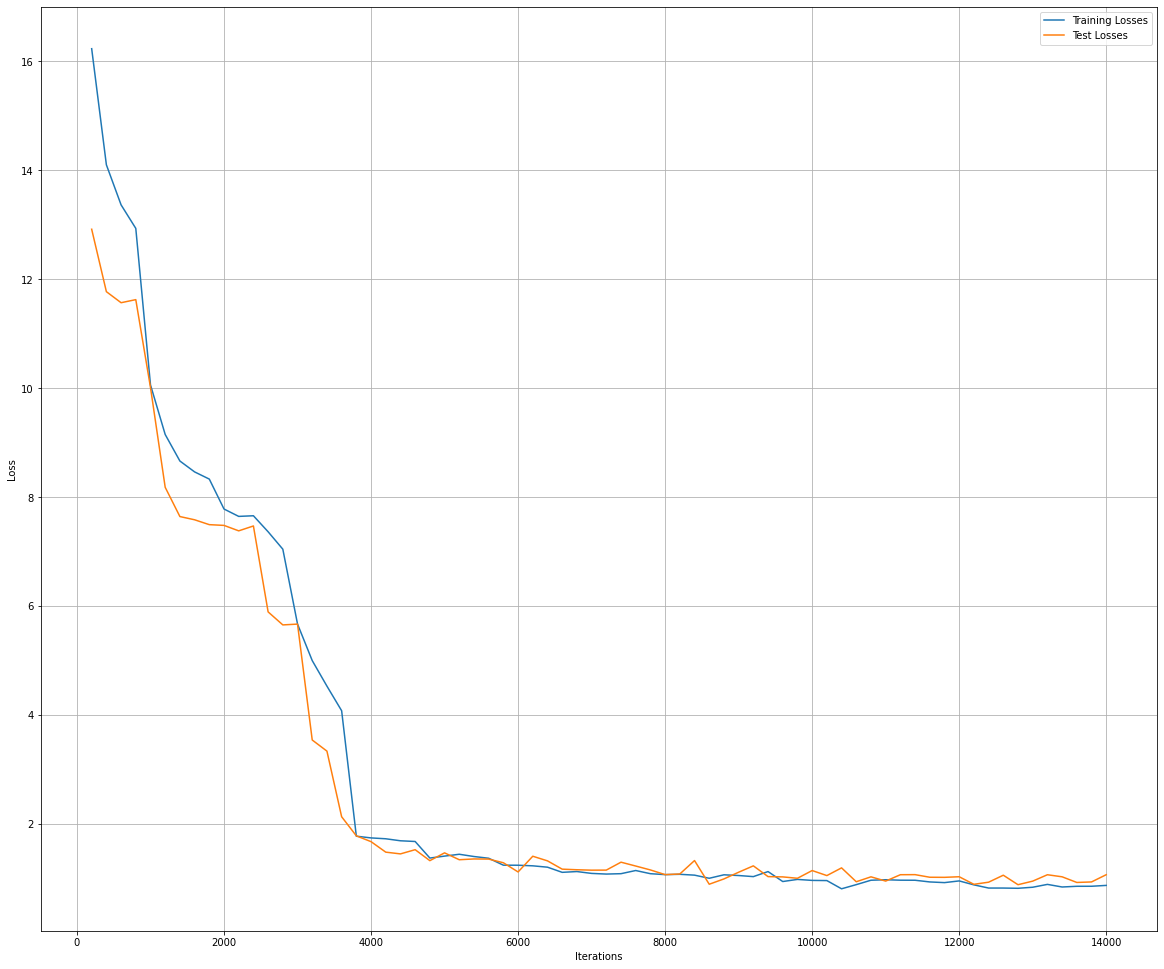

In [67]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn.functional as F

def train(model, optimizer, train_loader, test_loader, epochs, plot_interval=200):
    training_loss_list = []
    test_loss_list = []
    iteration_counts = []
    current_iteration = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.view(images.size(0), -1), labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()  
            optimizer.zero_grad()
            outputs = model(images)
            loss = model.entropy_class_loss(outputs, labels_one_hot) 
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            current_iteration += 1

            if current_iteration % plot_interval == 0:
                iteration_counts.append(current_iteration)
                avg_train_loss = running_loss / (batch_idx + 1)
                training_loss_list.append(avg_train_loss)

                model.eval()
                total_test_loss = 0
                total_test_samples = 0
                with torch.no_grad():
                    for test_images, test_labels in test_loader:
                        test_images, test_labels = test_images.view(test_images.size(0), -1), test_labels
                        
                        test_outputs = model(test_images)
                        test_labels_one_hot = F.one_hot(test_labels, num_classes=10).float()
                        test_loss = model.entropy_class_loss(test_outputs, test_labels_one_hot)
                        total_test_loss += test_loss.item() * test_images.size(0)
                        total_test_samples += test_images.size(0)
                
                avg_test_loss = total_test_loss / total_test_samples
                test_loss_list.append(avg_test_loss)
                print(f'Current Iteration [{current_iteration}], Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        print(f'Epoch [{epoch + 1}/{epochs}]')

    plt.figure(figsize=(20, 17))
    plt.plot(iteration_counts, training_loss_list, label='Training Losses')
    plt.plot(iteration_counts, test_loss_list, label='Test Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
 
    plt.legend()
    plt.grid(True)
    plt.show()

model = MLP_torch()
optimizer = Adam(model.parameters())
train(model, optimizer, train_loader, test_loader, epochs=15)


In [68]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def final_test(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.view(images.size(0), -1) 
            labels = labels
            
            outputs = model(images) 
            _, preds = torch.max(outputs, 1)  
            all_preds.append(preds.cpu().numpy())  
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:\n', conf_matrix)
    
    plt.figure(figsize=(20, 17))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Final Test Accuracy: 96.23%
Confusion Matrix:
 [[ 969    0    2    2    0    2    1    1    3    0]
 [   0 1123    2    3    0    1    2    1    3    0]
 [   6    1 1003    3    1    1    2    8    7    0]
 [   0    0    6  986    0    6    0    7    4    1]
 [   2    0    6    0  932    3   11    2    8   18]
 [   4    1    0   30    0  842    5    2    7    1]
 [  12    2    9    1    2    9  917    0    6    0]
 [   1    7   12    3    0    2    1  997    4    1]
 [   4    0    8   10    1    6    3    6  935    1]
 [   5    6    0   14   21    8    1   20   15  919]]


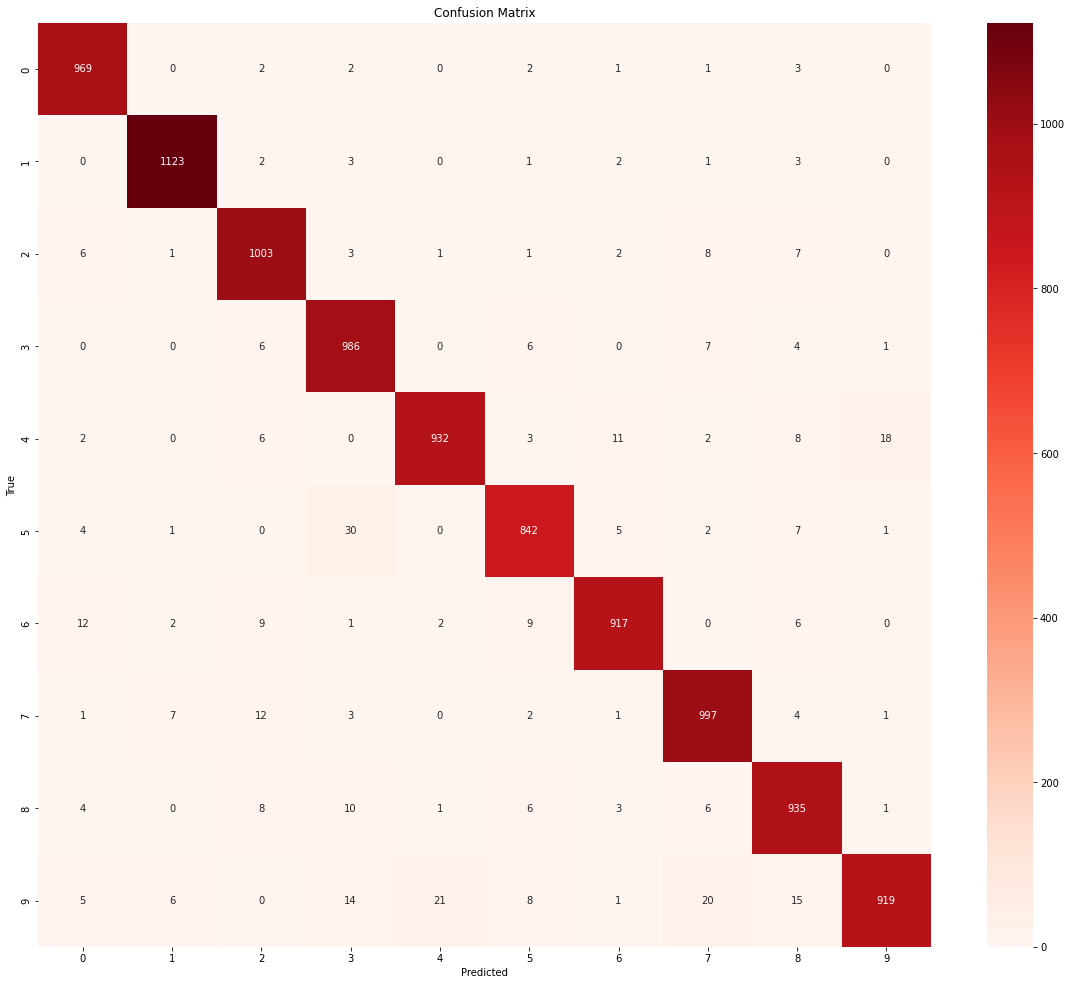

In [69]:

final_test(model, test_loader)


Final Test Accuracy: 96.87%
Confusion Matrix:
 [[5844    0   17    1    3   12   10    1   31    4]
 [   0 6621   48   18    6    2    2   14   30    1]
 [  14    7 5827   20   17    6    5   32   27    3]
 [   2    5   48 5957    0   28    2   39   40   10]
 [   5   17   27    0 5626    8   41   22   30   66]
 [  15    4   16  142    6 5155   25   11   40    7]
 [  37    5   24    0    5   52 5779    0   16    0]
 [   3   18   40   15   27    2    3 6129   10   18]
 [   7   19   37   56    2   35   15    5 5671    4]
 [  20   15    1   73   85   33    1  157   50 5514]]


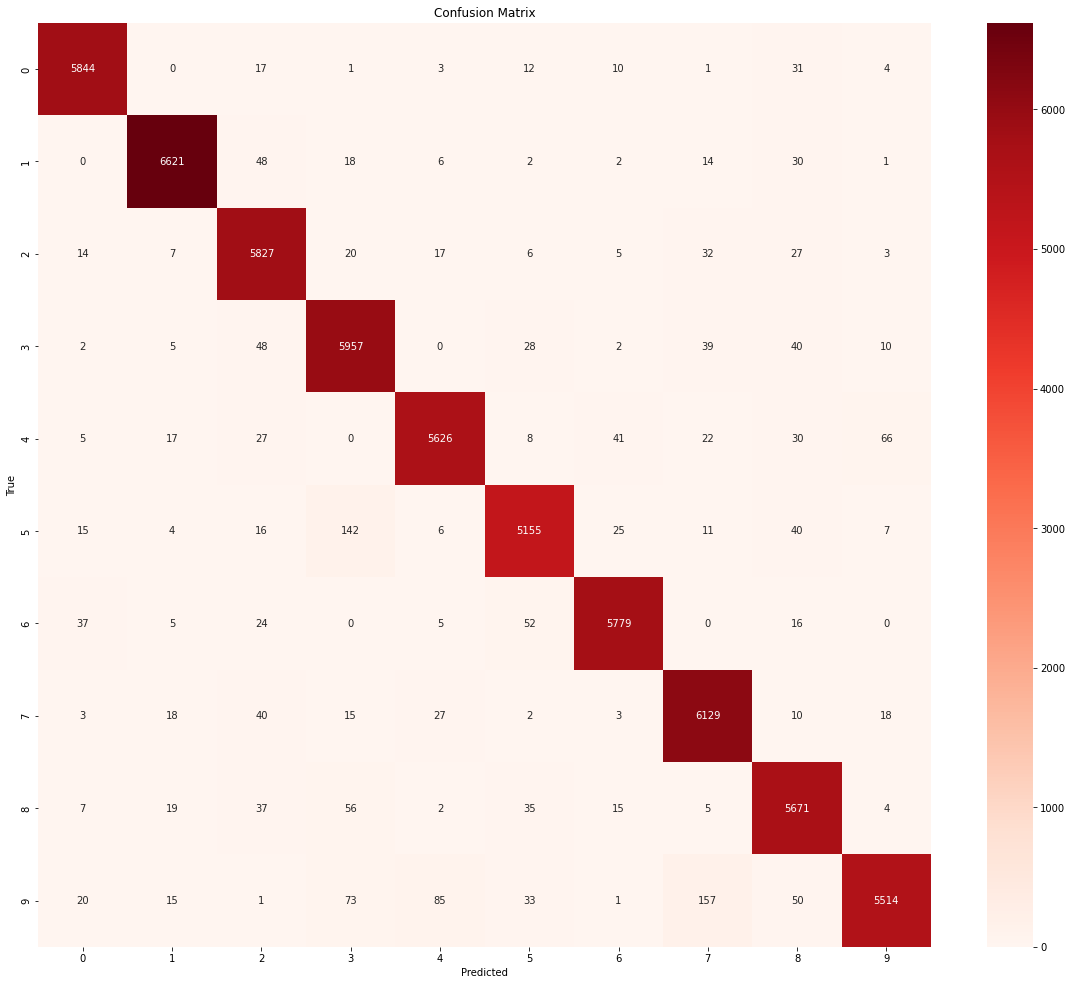

In [70]:

final_test(model, train_loader)


TANH

In [71]:
### Importing the dataset - in the form of batches - using dataloader package - mini batch descent - size =64
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP_torch(nn.Module):
    def __init__(self, input_layer_size=784, first_hidden_layer_size=500, 
                 second_hidden_layer_size=250, third_hidden_layer_size=100, 
                 output_layer_size=10):
        super(MLP_torch, self).__init__()
        self.first_layer = nn.Linear(input_layer_size, first_hidden_layer_size)
        self.second_layer = nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_layer = nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
        self.output_layer = nn.Linear(third_hidden_layer_size, output_layer_size)

    def forward(self, x):
        x = torch.tanh(self.first_layer(x))
        x = torch.tanh(self.second_layer(x))
        x = torch.tanh(self.third_layer(x))
        x = self.output_layer(x)  
        x = torch.softmax(x, dim=1)
        return x

    def entropy_class_loss(self, Y, Y_hat):
        epsilon = 1e-10
        Y_hat = torch.clamp(Y_hat, epsilon, 1. - epsilon)
        loss = -torch.sum(Y * torch.log(Y_hat)) / Y.size(0)
        return loss

Current Iteration 200, Training Loss: 7.3515, Test Loss: 3.6744
Current Iteration 400, Training Loss: 5.1583, Test Loss: 2.2069
Current Iteration 600, Training Loss: 4.2415, Test Loss: 2.1752
Current Iteration 800, Training Loss: 3.8239, Test Loss: 2.3268
Epoch 1/15
Current Iteration 1000, Training Loss: 1.9836, Test Loss: 2.0245
Current Iteration 1200, Training Loss: 2.0903, Test Loss: 2.4702
Current Iteration 1400, Training Loss: 2.0462, Test Loss: 1.6834
Current Iteration 1600, Training Loss: 2.0011, Test Loss: 1.7775
Current Iteration 1800, Training Loss: 2.0016, Test Loss: 2.0025
Epoch 2/15
Current Iteration 2000, Training Loss: 1.6379, Test Loss: 1.6093
Current Iteration 2200, Training Loss: 1.7474, Test Loss: 1.6699
Current Iteration 2400, Training Loss: 1.7463, Test Loss: 2.0954
Current Iteration 2600, Training Loss: 1.7792, Test Loss: 1.7126
Current Iteration 2800, Training Loss: 1.7581, Test Loss: 1.7391
Epoch 3/15
Current Iteration 3000, Training Loss: 1.6594, Test Loss: 1.4

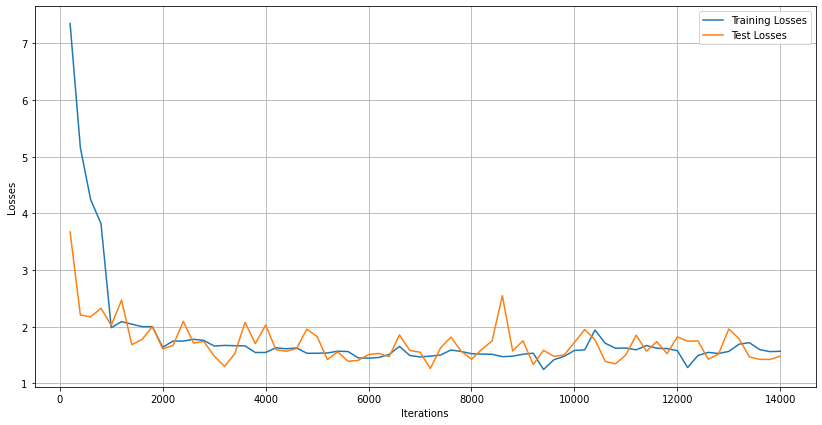

In [73]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn.functional as F

def train(model, optimizer, train_loader, test_loader, epochs, plot_interval=200, device='cpu'):
    training_loss_list = []
    test_loss_list = []
    iteration_counts = []
    current_iteration = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)  
            optimizer.zero_grad()
            outputs = model(images)
            loss = model.entropy_class_loss(outputs, labels_one_hot) 

        
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            current_iteration += 1

            if current_iteration % plot_interval == 0:
                iteration_counts.append(current_iteration)
                avg_train_loss = running_loss / (batch_idx + 1)
                training_loss_list.append(avg_train_loss)

                model.eval()
                total_test_loss = 0
                total_test_samples = 0
                with torch.no_grad():
                    for test_images, test_labels in test_loader:
                        test_images, test_labels = test_images.view(test_images.size(0), -1).to(device), test_labels.to(device)
                        
                        test_outputs = model(test_images)
                        test_labels_one_hot = F.one_hot(test_labels, num_classes=10).float().to(device)
                        test_loss = model.entropy_class_loss(test_outputs, test_labels_one_hot)
                        total_test_loss += test_loss.item() * test_images.size(0)
                        total_test_samples += test_images.size(0)
                
                avg_test_loss = total_test_loss / total_test_samples
                test_loss_list.append(avg_test_loss)
                print(f'Current Iteration {current_iteration}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        print(f'Epoch {epoch + 1}/{epochs}')

    plt.figure(figsize=(20, 17))
    plt.plot(iteration_counts, training_loss_list, label='Training Losses')
    plt.plot(iteration_counts, test_loss_list, label='Test Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

model = MLP_torch()
optimizer = Adam(model.parameters())
train(model, optimizer, train_loader, test_loader, epochs=15)


In [74]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def final_test(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images) 
            _, preds = torch.max(outputs, 1)  
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Test Accuracy: {accuracy * 100:.2f}%')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



Final Test Accuracy: 92.18%


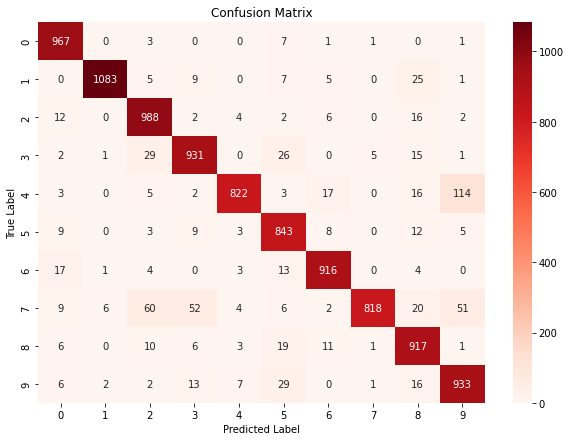

In [75]:
final_test(model, test_loader)

Final Test Accuracy: 92.35%


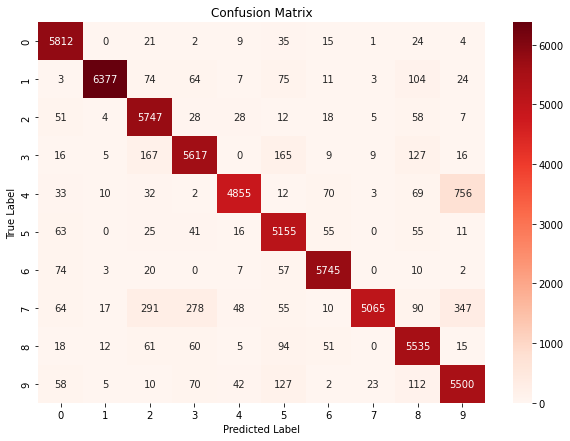

In [76]:
final_test(model, train_loader)